# DSND Capstone: Anomaly detection and forecasting of permeate breakthrough  

## Executive Summary:  

### Ultrafiltration Process
In the food and biochemical industry, the use of Ultrafiltration (UF) is a key unit operation to purify the product of interest. The feed enters the UF and and based on the pore size of the membrane, substances larger than the pore size, remains in the **concentrate (product)** and substances smaller than the pore size goes into the **permeate (waste)**.  

![alt text](https://www.crs-reprocessing.com/wp-content/uploads/2015/08/CRS_ToughUltraFiltration_Diagram_V4.png "Ultrafiltration Process")
*Image courtesy www.crs-reprocessing.com*


The pore size of the UF membrane, depending on the application, is on the order of 10 - 100 Kilo daltons. It is because of this, that it is possible to separate proteins, and increases the concentration of proteins in the concentrate stream by removing water and salts, leaving behind the product of interest.  

![alt text](https://synderfiltration.com/2014/wp-content/uploads/2014/05/UF-black-font-623x351.gif "Ultrafiltration Overview")
*Image courtesy www.synderfiltration.com*


However, over time, the membrane degrades, and the protein goes into the permeate. Since the permeate is a waste stream, we are essentially throwing out the product we wish to sell.  

### Problem Statement: 
In this project, by analyzing the historical permeate values, the aim is to detect breakthrough (high permeate values) and provide feedback to the engineers when the UF membranes should be replaced, thereby having a more reliable production process and reducing product loss. 

In other words, we wish to develop a robust methodology to predict when there is **permeate breakthrough (high levels of product in the permeate)** and predict what the future values will be.  

### Methodology

Given that the records of when the historical breakthrough are inconsistent, features for breakthrough will be created.
We will then evaluate methods for outlier detection (PCA and Autoencoder model) and will evaluate the use of Exponential moving averages and a more sophisticated LSTM model to forecast the future permeate values.  
The following  metrics were used to ascertain how well the model performs:  
* For anomaly detection, we will use accuracy and the F-score.
* For forecasting, we will use the mean squared error (MSE) of the test set.

### Results

#### Outlier Detection

The PCA analysis shows that the outliers can most likely be classified as shown by the red cluster below.

<p align="center">
  <img src="pca.png" width="800">
</p>

Likewise, a more advanced autoencoder model is able to capture when there is breakthrough with an Accuracy score of 0.9715, Precision score of 0.8438 and F-score of  0.7714 on the test set.

<p align="center">
  <img src="autoencoder.png" width="800">
</p>

Below the metrics for the autoencoder model is shown

<p align="center">
  <img src="score.png" width="800">
</p>

#### Forecasting permeate values

The simple EMA does a good job of tracking the trends but usually lags the movement of the new data as shown below. This particular analysis shows that after a major peak using the EMA, it takes about one year before there is another major peak (It is assumed the membranes are replaced after a major peak which causes a reduction of the permeate values).
This is actually a much shorter period than which the manufacture says should be closer to 2 years.

<p align="center">
  <img src="ema.png" width="800">
</p>

The LSTM does a poor job of predicting the actual permeate values but does an excellent job of predicting the EMA (shown below) and standard deviation. This can then be used to enable longer term predictions compared to just using the EMA model.

<p align="center">
  <img src="LSTM.png" width="800">
</p>

### Future work

Given more time, theses are areas of focus which should be investigated:

* The LSTM does a good job at predicting the mean and standard deviation of the future values. It could be interesting to evaluate if we can reconstruct the probability of what the future values would be.
* The use of gradients or % change between values should be investigated. While the moving average has been a successful feature, given that the permeate samples are not taken at regular intervals, a gradient may give more useful information.
* Evaluate different model parameters:
    - loss functions and  optimizers.
    - Activation function: relu 


### Conclusion

In this work we have evaluated various methods to predict when there is permeate breakthrough and the autoencoder model seems quite promising, but should be combined with conventional statistic process control metrics to increase its robustness.

Likewise, the EMA and LSTM provide different outcomes. The EMA smooths the time series data and gives the trend over time. This combined with the LSTM enables us to make future predictions on the trends in the future.


## Dataset

Scaled permeate data, **permeate_data.csv** has kindly been provided by **Novozymes AS**. The use of this dataset is solely to complete and assess the data mining task which is part of the  **DSND Capstone: Anomaly detection and forecasting of permeate breakthrough**  for the Udacity Data Science Nanodegree program. You are prohibited from using the **Novozymes AS** data in any other context.

The dataset, has already been cleaned and scaled and the  **mean_value_scaled** column contains the  scaled permeate values between 0 - 1.    
Product names  have been dropped and what is left are the dates when the measurement were taken **sample_created_date**.  

## Requirements 
The following  libraries were used to produce the results below: 

* cufflinks==0.16.0
* keras==2.3.0 
* matplotlib==2.1.2
* numpy==1.17.2
* pandas==0.22.0
* plotly==3.10.0
* scikit-learn==0.19.1
* scipy==1.0.0
* tensorflow==1.14.0 

# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

# THese two solutions dont seem to work to get repoducable results using keras in a jupyter notebook
# https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
# https://stackoverflow.com/questions/50659482/why-cant-i-get-reproducible-results-in-keras-even-though-i-set-the-random-seeds    
    
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import sys
import time
from pathlib import Path

import pandas as pd

#Load ploting tools
import seaborn as sns
sns.set(color_codes=True)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import cufflinks as cf
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

from tensorflow import keras
from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json


import math
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers


from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, fbeta_score, mean_squared_error
from sklearn.decomposition import PCA

import logging
from tqdm._tqdm_notebook import tqdm_notebook
import pickle

import IPython.display
from IPython.display import Image
IPython.core.display.display(IPython.core.display.HTML('<style>.container { width:100% !important; }</style>'))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Using TensorFlow backend.


# Load the scaled  permeate 

In [2]:
#Data sourrce 
from pathlib import Path
file1="permeate_data.csv"
DataSource = Path.cwd()  / file1

# Load the Data
df_uf = pd.read_csv(DataSource)

# convert date string to date
df_uf['sample_created_date']=pd.to_datetime(df_uf['sample_created_date'])
df_uf.sort_values(by='sample_created_date',ascending=True,inplace=True)

In [3]:
df_uf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2193 entries, 0 to 2192
Data columns (total 2 columns):
sample_created_date    2193 non-null datetime64[ns]
mean_value_scaled      2193 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 51.4 KB


In [4]:
df_uf.head()

,sample_created_date,mean_value_scaled
0,2009-07-08,0.000739
1,2009-07-14,0.001776
2,2009-07-15,0.002695
3,2009-07-16,0.079203
4,2009-07-17,0.003977


## Plot of scaled data

It can be seen that there are periods of high permeate values (above 0.4). Generally, the reduction in the high permeate values would be due to the new membranes being installed which would cause the permeate values to return to normal values.

In [5]:
df_uf.iplot(x='sample_created_date', y='mean_value_scaled', xTitle='Date', yTitle='Scaled Permeate Values',title='Permeate values over time', colors='blue')

## Distribution of the scaled data

The distribution is right skewed. The Box plot identifies an outlier as any data point that is located outside the “whiskers” of the boxplot (1.5 times the interquartile range above the upper quartile and below the lower quartile).  

This then gives that any value over **0.21** to be an outlier. This seems a bit to conservative, but works as a starting point in the analysis.

In [6]:
df_uf['mean_value_scaled'].iplot(kind='histogram', xTitle='Scaled Permeate Values', yTitle='Count',title='Histogram of permeate values', colors='blue')

In [7]:
df_uf['mean_value_scaled'].iplot(kind='box',boxpoints='outliers', yTitle='Scaled Permeate Value',title='Boxplot of permeate values',colors='blue')

# Create training dataset features

Since the record of when the historical breakthrough are inconsistent, features for when breakthrough occurs will be created based on 1.5 standard deviations. Values below  1.5 standard deviations are categorized as normal operation (0) and values above are categorized breakthrough (1). Other features are created:  
* standard deviation
* Moving average
* Exponential moving average 

In the end I've settled on using the standard deviation and Exponential moving average of previous n samples as addition features.   
These seem to capture the trend for the changes in the permeate values.
**Note: Tukey's fences could be used instead of the std for the cutoff**

In [8]:
def permeate_features(df, n_window=7,type_split='ratio',std_val=1.5,stat='ema_avg'):
    """ Function to test different features and create labels for when there is normal operation (0) and breakthrough (1)
    
    Parameters:
    
        df (Dataframe): Dataframe of the permeate samples
        n_window (int):  number of pervious values to use for the mean and std
        type_split (string): chose if to spit the data based on the standard deviation (std) or based on a ratio (ratio)
        std_val (int): number of standard deviations 
        stat= (string): chose which stat to return  'ema_avg' or 'moving_avg'
        
    Returns:
        X_train (Dataframe): Dataframe of the training dataset features
        X_test (Dataframe): Dataframe of the test dataset features
        y_train (Dataframe): Dataframe of the training  target
        y_test (Dataframe): Dataframe of the test target
        df (Dataframe): Dataframe of the permeate samples with the target and new features 

    
    """
    # Creat features moving average, EMA and std
    # note pandas eam is sligly different to the classic ema 
    # https://stackoverflow.com/questions/48775841/pandas-ema-not-matching-the-stocks-ema
    df['moving_avg'] =df[['mean_value_scaled']].rolling(window=n_window).mean()
    df['ema_avg'] =df[['mean_value_scaled']].ewm(span=n_window,adjust=False).mean()
    df['std'] = df[['mean_value_scaled']].rolling(window=n_window).std()
    df.fillna(0,inplace=True)
    
    
    # Get cut off for the target using the std_val
    df_mean = df['mean_value_scaled'].mean()
    df_std = df['mean_value_scaled'].std()
    cutt_off = df_mean + std_val*df_std
    
    df['Target'] = np.where(df['mean_value_scaled'] >= cutt_off,1,0)
    
    # select training features based on std
    if type_split == 'std':
      
        criteria = (df[stat] < cutt_off)
        X_train = df[criteria]
        
        criteria = (df[stat] > cutt_off)
        X_test = df[criteria]
        
        X_train = X_train[['mean_value_scaled',stat,'std','Target']].copy()
        X_test = X_test[['mean_value_scaled',stat,'std','Target']].copy()
        
        y_train = X_train[['Target']].copy()
        y_test = X_test[['Target']].copy()
        X_train.drop(columns=['Target'],axis=1, inplace=True)
        X_test.drop(columns=['Target'],axis=1,inplace=True)
        
    elif type_split == 'ratio':
    
        # Select data based on values
        n=df.shape[0]
        dataset_train = df.iloc[0:int(n*0.80)]
        dataset_test = df.iloc[int(n*0.80):]
    
        X_train = dataset_train[['mean_value_scaled',stat,'std','Target']].copy()
        X_test = dataset_test[['mean_value_scaled',stat,'std','Target']].copy()
        y_train = X_train[['Target']].copy()
        y_test = X_test[['Target']].copy()
        X_train.drop(columns=['Target'],axis=1, inplace=True)
        X_test.drop(columns=['Target'],axis=1,inplace=True)
    
    return X_train, X_test, y_train, y_test, df

## Split into testing and training 

In [9]:
# split into test and train
STAT='ema_avg'
X_train, X_test, y_train, y_test, df_data= permeate_features(df_uf, n_window=10, type_split='ratio', stat=STAT)

In [10]:
X_train.shape, X_test.shape

((1754, 3), (439, 3))

### Full data set

In [11]:
df_data[['moving_avg','mean_value_scaled',STAT]].iplot( xTitle='Sample', yTitle='Scaled Permeate Values',title='Permeate values full dataset')

### Train data set

In [12]:
X_train[[STAT,'mean_value_scaled']].iplot(xTitle='Sample', yTitle='Scaled Permeate Values',title='Permeate values train dataset')

### Test data set

In [13]:
X_test[[STAT,'mean_value_scaled']].iplot(xTitle='Sample', yTitle='Scaled Permeate Values',title='Permeate values test dataset')

# Detecting breakthrough using anomaly detection

In this section we will implement the methodology by [Flovik and co-workers](https://towardsdatascience.com/machine-learning-for-anomaly-detection-and-condition-monitoring-d4614e7de770) for anomaly detection. For their case, they used a PCA model and autoencoder model to predict when a bearing was going to break. We will adapt their implementation and evaluate which one fits our case better.  

We will evaluate accuracy presion anf the F sore

## PCA analysis for  anomaly detection

As dealing with high dimensional sensor data is often challenging, there are several techniques to reduce the number of variables (dimensionality reduction). One of the main techniques is principal component analysis (PCA). 

As an initial attempt, lets compress data down to  two main principal components.

In [14]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

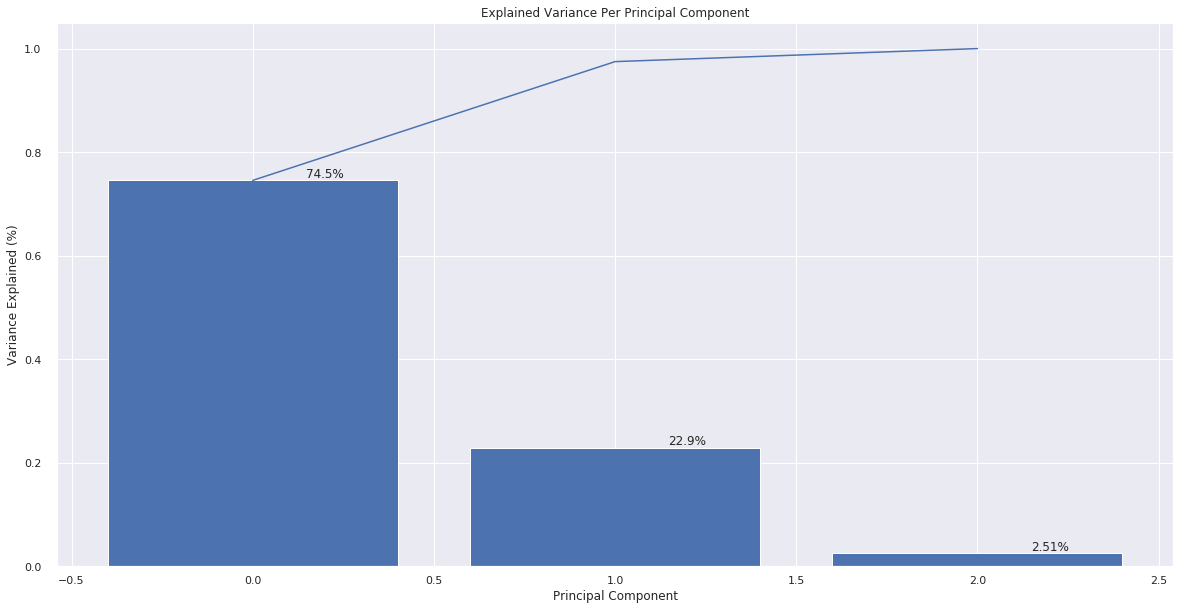

In [15]:
pca = PCA()
X_train_PCA = pca.fit_transform(X_train)
scree_plot(pca)

It can be seen that 97.5 % of the variance can be explained by the first two principal components (PC). 

Each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.


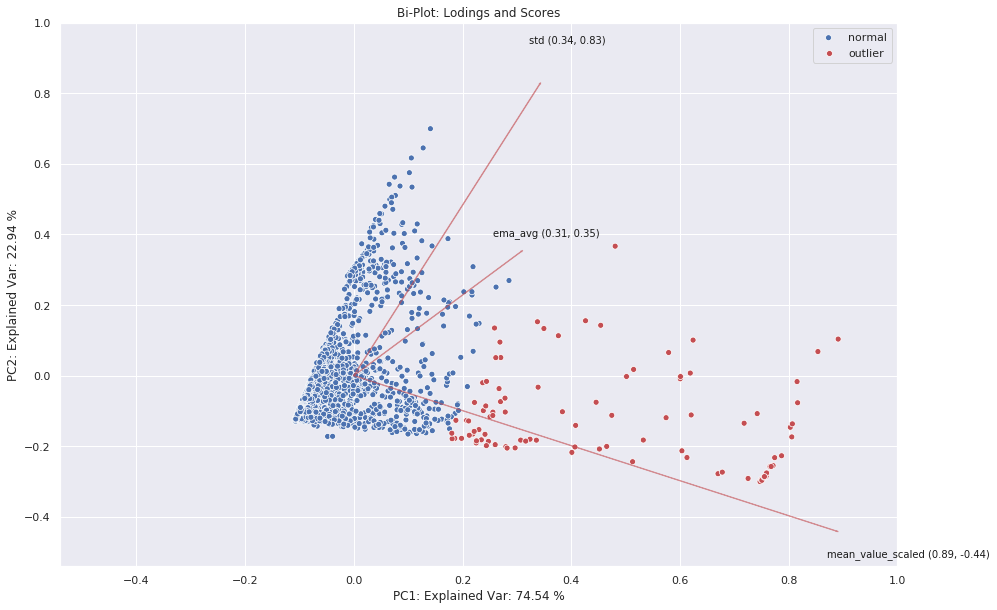

In [16]:
def myplot(score,coeff,labels=['mean_value_scaled', STAT ,'std'],exp_var=pca.explained_variance_ratio_, target=y_train):
    
    """ Bi Plot shoing lodings and scores 
  
    Parameters
    
    score (np.array): scores from pca
    coeff (np.array): weights from pca
    lables (slist): names features
    
    Returns
    
    df (dataframe): Weights of the first two components
    
    
    """
    
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    
    plt.figure( figsize = (15,10))

    
    #plt.rcParams.update({'font.size': 16})
    
    # creat color list for high values
    color_list = [{0:"b",1:"r"}[x] for x in target['Target']]
    
    # PCA Data
    sns.scatterplot(xs * scalex,ys * scaley, color=color_list)
    # Quick fix outlier ledgend
    sns.scatterplot([0.6, 0.5] ,[0,0], color='r')
   
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "{} ({:.2f}, {:.2f})".format(labels[i],(coeff[i,0]),(coeff[i,1])) , color = 'k', ha = 'center', va = 'center')
        #labels[i] + {:.2f}.format(str(coeff[i,0]))+ str(coeff[i,1]))
    plt.xlim(coeff.min()-.1,1)
    plt.ylim(coeff.min()-.1,1)
    plt.xlabel("PC{}: Explained Var: {:.2f} %".format(1,exp_var[0]*100))
    plt.ylabel("PC{}: Explained Var: {:.2f} %".format(2,exp_var[1]*100))
    plt.title("Bi-Plot: Lodings and Scores")
    plt.legend(('normal','outlier')) 
    
    
    SMALL_SIZE = 14
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 18

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    # dataframe of weights of first 2 components
    n=1
    
    components = pd.DataFrame(np.round(pca.components_[n - 1: n], 4), columns = labels)
    components.index = ['PC1']
    

    n=2
    components2 = pd.DataFrame(np.round(pca.components_[n - 1: n], 4), columns = labels)
    components2.index = ['PC2']
    
    df = pd.concat([components, components2])
    
    
    return df.T

# Biplot of the fitst 2 components and the loadings
df_pca_weights=myplot(X_train_PCA[:,0:2],np.transpose(pca.components_[0:2, :]))


It is now possible to project the entire dataset to a lower dimensional space but retain most of the information. The Bi-Plot above shows the loadings and scores for the first two principal component

For the first PC, all the features are positive. This is reasonable given that if the **mean_value_scaled** is increasing the **std** will also increase along with the **ema_avg**. When the two PC are included the **ema_avg** and **std** are more closely correlated but less so to the **mean_value_scaled**.

It could also bee seen in the Bi-Plot that there is a separation between the normal permeate values (blue) and the outliers (red).

We will now evaluate using the an auto encoder to identify outliers.

## Autoencoder model for anomaly detection

[Autoencoder](https://www.jeremyjordan.me/autoencoders/) is a neural network architecture which imposes a bottleneck in the network which forces a compressed knowledge representation of the original input. If some sort of structure exists in the data (ie. correlations between input features), this structure can be learned and consequently leveraged when forcing the input through the network's bottleneck.  

![alt text](https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-06-at-3.17.13-PM.png "Auroencoder")
*Image courtesy www.jeremyjordan.me/autoencoders/*  

Autoencoders, by design, reduces data dimensions by learning how to ignore the noise in the data.  

In the bearing example by  [Flovik and co-workers](https://towardsdatascience.com/machine-learning-for-anomaly-detection-and-condition-monitoring-d4614e7de770) they were able to predict the breakdown of the bearing  days in advance. The aim is to evaluate if this same behavior is seen in our permeate data. This will be quite useful for the engineers to be able to identify  when the UF membranes should be replaced. Currently,  control charts are used to identify if there is a breakthrough, but this methodology relies on at least 2 to 3 data points being above the threshold value. A method that can predict days in advance will be very useful.


Hence, the Idea is to use an autoencoder neural network to “compress” the data to a low dimensional representation, which captures the correlations and interactions between the various variables. (Essentially the same principle as the PCA model, but here we also allow for non-linearities among the input variables).


### Defining the Autoencoder network:

We use a 3 layer neural network: First layer has 20 nodes, middle layer has 3 nodes, and third layer has 20 nodes. We use the mean square error as loss function, and train the model using the “Adam” optimizer.  

In [17]:
# visulise the loss

def trainingLoss(history):
    
    """ Plot traning and validation los for lkeras history object"""

    # Visualize the training progress
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=history.history['loss'],
                                    mode='lines',
                                    name='Train',
                                    line=dict(color='blue', width=2)))

    fig.add_trace(go.Scatter(y=history.history['val_loss'],
                                    mode='lines',
                                    name='Test',
                                    line=dict(color='orange', width=2)))

    fig.layout.update(  title=('Model Loss'),
                                    xaxis_title='Epoch',
                                    yaxis_title=('Loss'))
    fig.show()
    

# more info on elu  https://arxiv.org/abs/1511.07289
act_func = 'relu'

# Build the model
# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
n=20
model.add(Dense(n,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )
# More info on glorot http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
model.add(Dense(3,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(n,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

# Compiling the model
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.summary()
# Train model x epochs, batch size of n: 
NUM_EPOCHS=500
BATCH_SIZE=32

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 63        
_________________________________________________________________
dense_3 (Dense)              (None, 20)                80        
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 63        
Total params: 286
Trainable params: 286
Non-trainable params: 0
_________________________________________________________________


### Fitting the model or loading the pre-trained model

In [18]:
Fitting=False
filepath='model_autoencoder.hdf5'

if Fitting:

    es =[EarlyStopping(monitor='val_loss', patience=100)]

    history=model.fit(np.array(X_train),np.array(X_train),
                      batch_size=BATCH_SIZE, 
                      epochs=NUM_EPOCHS,
                      validation_split=0.05,
                      verbose = 1,
                      callbacks=[])
        
    model.save(filepath)
    
    trainingLoss(history)   
else:
    
    model = keras.models.load_model('AutoEncoder.h5')
    model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 20)                80        
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 63        
_________________________________________________________________
dense_15 (Dense)             (None, 20)                80        
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 63        
Total params: 286
Trainable params: 286
Non-trainable params: 0
_________________________________________________________________


## Distribution of loss function in the training set:

By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level”, and that any flagged anomalies should be statistically significant above the noise background.

(0.0, 0.02)

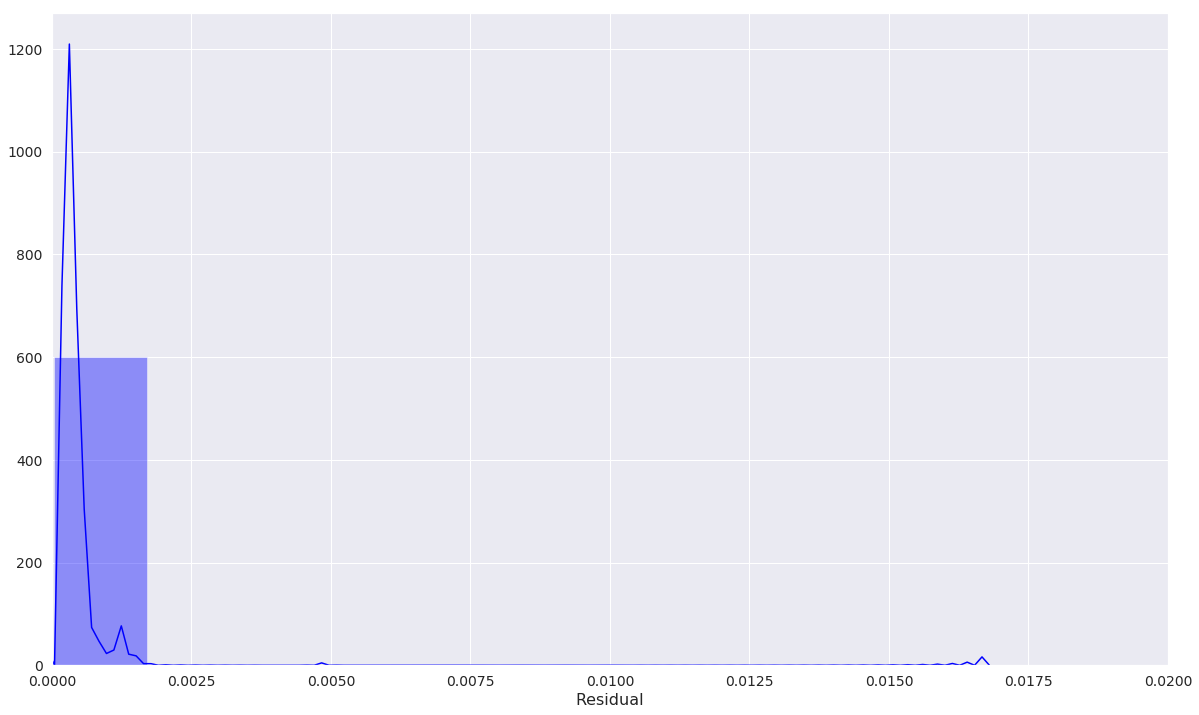

In [19]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Residual'] = np.mean(np.abs(X_pred-X_train), axis = 1)

plt.figure( figsize = (20,12))
sns.distplot(scored['Residual'],
             bins = 10, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.02])

In [20]:
scored['Residual'].iplot(kind='box',boxpoints='outliers', yTitle='Residual',title='Boxplot of the residual in the training set,',colors='blue')

From the above  box blot, a threshold value of **678e-6** is initially used for flagging for an anomaly (upper fence of box plot). This can be tuned to optimize the f1 score. We can then calculate the residual for the test set, to check when the output crosses the anomaly threshold.

**Note: even though setting the [random seed](https://github.com/keras-team/keras/issues/439), I'm still unable to get reproducible results and will need to dig into this issue as future work ... hence the best model is saved and loaded**.

In [21]:
q75, q25 = np.percentile(scored['Residual'], [75 ,25])
iqr = q75 - q25
 
tmin = q25 - (iqr*1.5)
tmax = q75 + (iqr*1.5)

print(tmax) 

0.0006776920781169417


In [22]:
# Evaluate test data
threshold=tmax

X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored_test = pd.DataFrame(index=X_test.index)
scored_test['Residual'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored_test['Threshold'] = threshold
scored_test['Anomaly'] = scored_test['Residual'] > scored_test['Threshold']
scored_test['Target_pred'] = np.where(scored_test['Anomaly']==True, 1, 0)
scored_test['Target']=y_test['Target'].copy()
scored_test['sample_created_date']=df_data.loc[X_test.index.tolist(),'sample_created_date'].copy()
scored_test.head()

,Residual,Threshold,Anomaly,Target_pred,Target,sample_created_date
1754,0.000064,0.000678,False,0,0,2017-07-22
1755,0.000061,0.000678,False,0,0,2017-07-23
1756,0.000102,0.000678,False,0,0,2017-07-24
1757,0.000060,0.000678,False,0,0,2017-07-25
1758,0.000057,0.000678,False,0,0,2017-07-27


We then calculate the same metrics also for the training set, and merge all data in a single dataframe:

In [23]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Residual'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = threshold
scored_train['Anomaly'] = scored_train['Residual'] > scored_train['Threshold']
scored_train['Target_pred'] = np.where(scored_train['Anomaly']==True, 1, 0)
scored_train['Target']=y_train['Target'].copy()
scored_train['sample_created_date']=df_data.loc[X_train.index.tolist(),'sample_created_date'].copy()
scored_train.head()

scored = pd.concat([scored_train, scored_test])

## Plot results from Autoencoder model:

Having calculated the loss distribution and the anomaly threshold, we can visualize the model output for the permeate values:

In [24]:
fig = go.Figure()
# scale target
n=0.01
fig.add_trace(go.Scatter(x=scored['sample_created_date'], y=scored['Target']*n,
                    mode='lines',
                    name='Target',
                    line=dict(color='grey', width=1)))
fig.add_trace(go.Scatter(x=scored['sample_created_date'], y=scored['Threshold'],
                    mode='lines',
                    name='Threshold',
                    line=dict(color='red', width=2)))
fig.add_trace(go.Scatter(x=scored_train['sample_created_date'], y=scored_train['Residual'],
                    mode='lines',
                    name='Train Dataset',
                    line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(x=scored_test['sample_created_date'], y=scored_test['Residual'],
                    mode='lines',
                    name='Test Dataset',
                    line=dict(color='green', width=2)))
fig.layout.update(yaxis_type="log",
                    title='Autoencoder outlier detection',
                    xaxis_title='Date',
                    yaxis_title='Residual')
fig.show()

### Metrics for Auto encoder

Accuracy alone doesn't tell the full story when you're working with a class-imbalanced data set, like this one, where there is a significant disparity between the number of positive and negative labels.

Hence we will also use the f1 score which is a balance of the  [precision and recall](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative).

#### Naive case
If we chose a model that always predicted outliers, what would  that model's accuracy and F-score be on this dataset? 

In [25]:
''' Given outlier as the positive class:

TP = np.sum(df_data['Target']) # Counting the ones as this is the naive case. 
FP = df_data['Target'].count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# Calculate accuracy, precision and recall for the Naive case
TP = np.sum(df_data['Target'])
FP = df_data['Target'].count() - TP
TN = 0
FN = 0


def manual_metrics(TP,FP,TN,FN):
    
    """ Calcualte accuracy recall and precision    """


    accuracy = (TP+TN)/(TP+FP+TN+FN) # accuracy is the fraction of predictions our model got right
    recall = TP/(TP+FN)              # What proportion of actual positives was identified correctly
    precision = (TP)/(TP+FP)         # What proportion of positive identifications was actually correct

    # Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
    beta = 0.5
    fscore = (1+beta**2)*(precision*recall)/(beta**2*precision+recall)
    
    # Print the results 
    print("Metrics: [Accuracy score: {:.4f}, Recall score: {:.4f}, Precision score: {:.4f}, F-score: {:.4f}]".format(accuracy, recall, precision, fscore))

    
# Metrics for the naive model    
manual_metrics(TP,FP,TN,FN)

Metrics: [Accuracy score: 0.0543, Recall score: 1.0000, Precision score: 0.0543, F-score: 0.0669]


#### Model metrics

We will calculate the  Accuracy and F_score for the training and test data and as seen below gives much better performance than the Naive case.  
**Naive Predictor: [Accuracy score: 0.0543, F-score: 0.0669]**

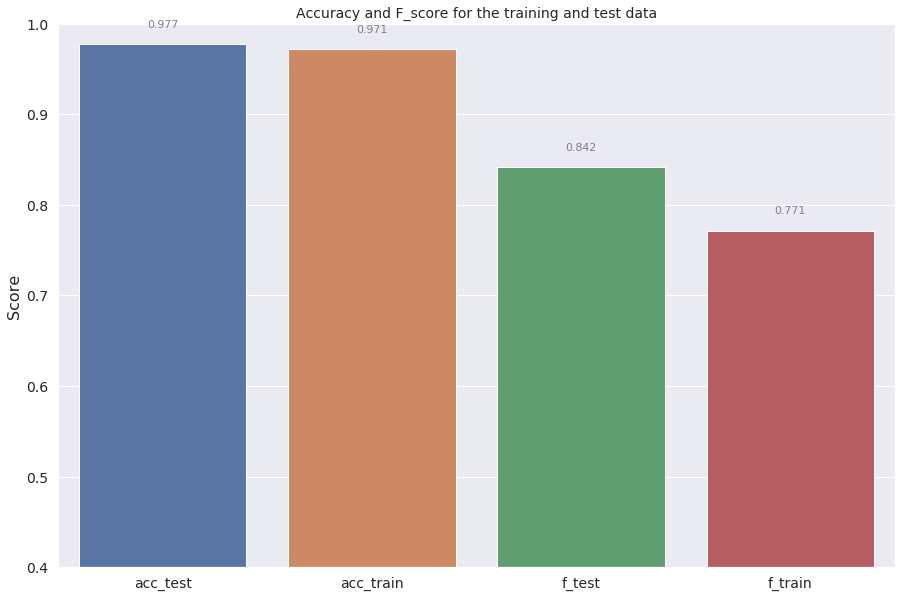

In [26]:
def metrics_data(scored_train, scored_test, Average): 
    """ Calculates the  Accuracy and F_score for the training and test data
  
    Parameters
    
    scored_test (dataframe): Test data results
    scored_train (dataframe): Train data results
    Average (string): Type averaging metric for Fbeta score (used in multiclass classification)
    
    Returns
    
    df (dataframe): Weights of the first two components
    """
    
    results = {}
    
    predictions_train=scored_train['Target_pred']
    predictions_test=scored_test['Target_pred']
    
    y_train=scored_train['Target']
    y_test=scored_test['Target']
  
    
    # Compute accuracy on the  training samples 
    results['acc_train'] = accuracy_score(y_train,predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train,predictions_train,beta=0.5,average=Average)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5,average=Average)
    
    # Plot results
    results=pd.DataFrame(results,index =[0])
    plt.figure( figsize = (15,10))
    ax=sns.barplot(data=results)
    plt.ylabel('Score')
    plt.ylim([0.4,1])
    plt.title('Accuracy and F_score for the training and test data')
    
    for p in ax.patches:
             ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
    
    return results


df_score=metrics_data(scored_train, scored_test,'binary')

In [27]:
# Manuall calcualtion to check whether the reported training and test performance are in fact correct
# Calculate accuracy, precision and recall for the Naive case
TP = scored_train['Target'][(scored_train['Target']==1) & (scored_train['Target_pred']==1)].count() # Reality: outlier, Model predict: Outlier
FP = scored_train['Target'][(scored_train['Target']==0) & (scored_train['Target_pred']==1)].count() # Reality: normal, Model predict: Outlier
TN = scored_train['Target'][(scored_train['Target']==0) & (scored_train['Target_pred']==0)].count() # Reality: normal, Model predict: normal
FN = scored_train['Target'][(scored_train['Target']==1) & (scored_train['Target_pred']==0)].count() # Reality: outlier, Model predict: normal

manual_metrics(TP,FP,TN,FN)

Metrics: [Accuracy score: 0.9715, Recall score: 0.5745, Precision score: 0.8438, F-score: 0.7714]


As can seen above the model gives very good performance in capturing the outliers and generalizes quite well to the test set. However, the test set has better scores than the training dataset.

This [stackoverflow](https://stats.stackexchange.com/questions/59630/test-accuracy-higher-than-training-how-to-interpret) discussion highlights that this can be due to:  
* How is the data is split (For future work we will look into different time periods ... shuffling doesn't make sense for time series data)
* Wrong calculation (This was manually checked on the training dataset and can be ruled out)
* Accuracy on a training set makes no sense in machine learning (ML methods are about performance on unseen data, thus they give no guarantees about this result (the model is not expected to re-implement the mechanism underlying the data like in statistical modeling))
* The sample size, (This is a legitimate issue given the dataset we have)
* Is the test data similar  to the training data (No, given this is time series data and physically the membranes can age at different rates)

# Predict future permeate values 

Time series modeling can be quite beneficial by using  historical data to predict what the future permeate values. We shall evaluate the use of moving averages and a special type of recurrent neural network, Long short-term memory (LSTM), to predict the future permeate values.

## Exponential moving Average (EMA) for predicting permeate value

In this case we evaluate the use of [EMA](https://www.datacamp.com/community/tutorials/lstm-python-stock-market) to smooth and predict the next value. 

In the exponential moving average method, you calculate xt+1 as,   
xt+1 = EMAt = γ × EMAt-1 + (1-γ) xt 

where EMA0 = 0 and EMA is the exponential moving average value you maintain over time.

The above equation basically calculates the exponential moving average from t+1 time step and uses that as the one step ahead prediction.  
γ decides what the contribution of the most recent prediction is to the EMA. For example, a γ=0.1 gets only 10% of the current value into the EMA preserving the effect of much older values. 

In [28]:
def permeate_features(df, decay = 0.9):
    """ Function to test different features and create labels for when there is normal operation (0) and breakthrough (1)
    
    Parameters:
    
        df (Dataframe): Dataframe of the permeate samples
        decay (int):  weight to place on the EMA
              
    Returns:
        df (Dataframe): Dataframe including the EMA
    
    """
    # Get permeate values
    x_train = df.loc[:,'mean_value_scaled'].values
    
    N = x_train.shape[0]

    run_avg_predictions = []
    run_avg_x = []
    mse_errors = []
    running_mean = 0.0
    run_avg_predictions.append(running_mean)
    
    # Calculate EMA
    for pred_idx in range(1,N):

        running_mean = running_mean*decay + (1.0-decay)*x_train[pred_idx-1]
        run_avg_predictions.append(running_mean)
    
    # add EMA to original df
    df['EMA'] = run_avg_predictions
    
    # Calculate MSE
    mse=(df['EMA']-df['mean_value_scaled'])**2
    
    
    # Plot results
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['sample_created_date'], y=df['mean_value_scaled'],
                        mode='lines',
                        name='EMA',
                        line=dict(color='blue', width=1)))
    fig.add_trace(go.Scatter(x=df['sample_created_date'], y=df['EMA'],
                        mode='lines',
                        name='mean_value_scaled',
                        line=dict(color='orange', width=2)))

    fig.layout.update(  title=("MSE error for EMA: {:.5f}".format(0.5*mse.mean())),
                        xaxis_title='Date',
                        yaxis_title='Scaled Permeate value')
    fig.show()
   
    return df

In [29]:
df_ema= permeate_features(df_data, decay = 0.9)

As seen above the EMA does a good job of capturing th general tend but it is usually lagging the the behavior of the current actual value.
It is essentially capturing the long term deterioration of the UF membranes. 
This particular analysis shows that after a major peak using the EMA, it takes about one year before there is another major peak (It is assumed the membranes are replaced after a major peak which causes a reduction of the permeate values).
This is actually a much shorter period than which the manufacture says should be closer to 2 years.
It may mean we need to evaluate the operating and cleaning conditions of the membranes, to see if this is having effect on the lifetime of the membranes.

## Long short-term memory (LSTM) for predicting permeate value

[Nayak and coworkers](https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944) used an LSTM  model to predict future stock prices. Unlike standard feedforward neural networks, LSTM has feedback connections. They are networks with loops in them, allowing information to persist.   
In the below diagram, a chunk of neural network, A, looks at some input xt and outputs a value ht. A loop allows information to be passed from one step of the network to the next.  

<img src=https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-rolled.png width="200">


More info in LSTM can be found [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

### Define the main functions for the LSTM model

In [30]:
def lstm_data(df_data, train_cols = ['mean_value_scaled',STAT,'std']):
    """ Function to return tsplit of test and training dataset
    
    Parameters:
    
        df_data (Dataframe): Dataframe of the permeate samples
        train_cols (list):  Columns of features
              
    Returns:
        x_train (Dataframe): Dataframe of the training dataset features
        x_test (Dataframe): Dataframe of the test dataset features
        x_train (Dataframe): Dataframe including dates for training dataset
        x_test (Dataframe): Dataframe including dates for test dataset
    
    """
    # Data for prediction
    df_train, df_test = train_test_split(df_data, train_size=0.8, test_size=0.2, shuffle=False)
       
    # Date
    t_train = df_train.loc[:,['sample_created_date','mean_value_scaled']].values
    t_test = df_test.loc[:,['sample_created_date','mean_value_scaled']].values
    
    # Features
    x_train = df_train.loc[:,train_cols].values
    x_test = df_test.loc[:,train_cols].values
    
    return x_train, x_test, t_train, t_test

def build_timeseries(mat, y_col_index, TIME_STEPS):
    """ Function to convert the data to LSTM format
    
    Parameters:
    
        mat (arry): array of permeate samples features
        y_col_index (int):  index of column that would act as output column (eg. index 0 is the mean_scaled_value)
              
    Returns:
       x (array): lstm array [ len(mat) - TIME_STEPS, time_steps, Features ]; a 3- dimensional array.
       y (array): output feature
    
    """
      
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    
    for i in (range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    # print("length of time-series i/o",x.shape,y.shape)
    return x, y

def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat
    
def lstm_train(df, params, output_y = 1,  train_cols = ['mean_value_scaled','EMA','std'],Verbose=0,plots=True):
    """ Function to train and predict the lstm model
    
    Parameters:
    
        df (Dataframe): Dataframe of the permeate samples
        parms (list):  List of the LSTM paramters
        output_y (int):  column index of the feature to predict (0 -perm value,1 -EMA, -2 STD)
        train_cols (list):  Columns of features
        Verbose (int):  Show lstm progress (0 = off , 1 = on)
        plots (bool):  Flag to turn plots on or off
              
    Returns:
        history (object): Object of lstm training
        lstm_model (object): Lstm model
        y_pred (array): prediction of lstm model for the test data
        y_test_t (array): test data
        error (float): MSE for y_pred and y_test_t
         
    """
    
    
    # Set up test and train data 
    x_train, x_test, t_train, t_test = lstm_data(df, train_cols)


    # LSTMs consume input in format [ batch_size, time_steps, Features ]; a 3- dimensional array.

    TIME_STEPS = params["time_steps"]
    BATCH_SIZE = params["batch_size"]

    # Train data set
    x_t, y_t = build_timeseries(x_train, output_y, TIME_STEPS)
    x_t = trim_dataset(x_t, BATCH_SIZE)
    y_t = trim_dataset(y_t, BATCH_SIZE)

    # test data set
    x_temp, y_temp = build_timeseries(x_test, output_y, TIME_STEPS)   
    
    
    # define lstm model
    act_func='elu'
    kernel_init='glorot_uniform'
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0,
                        recurrent_dropout=0.0, 
                        stateful=True, 
                        activation=act_func,
                        kernel_initializer=kernel_init, 
                        kernel_regularizer=regularizers.l2(0.0)))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(20,activation='elu', kernel_initializer=kernel_init))
    lstm_model.add(Dense(1,activation='relu', kernel_initializer=kernel_init))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    
    
    # Fit model
    history = lstm_model.fit(x_t, y_t, epochs=params["epochs"], verbose=Verbose, batch_size=BATCH_SIZE,
                            shuffle=False, validation_data=(trim_dataset(x_temp, BATCH_SIZE),
                            trim_dataset(y_temp, BATCH_SIZE)))
    
    # Predict validation
    y_pred = lstm_model.predict(trim_dataset(x_temp, BATCH_SIZE), batch_size=BATCH_SIZE)
    y_pred = y_pred.flatten()
    y_test_t = trim_dataset(y_temp, BATCH_SIZE)
    error = mean_squared_error(y_test_t, y_pred)
    
    if plots:
        # Visualize the training progress
        trainingLoss(history)

        # Visualize the prediction
        fig = go.Figure()
        fig.add_trace(go.Scatter(y=y_test_t,
                                mode='lines',
                                name='Prediction',
                                line=dict(color='blue', width=1)))

        fig.add_trace(go.Scatter(y=y_pred,
                                mode='lines',
                                name='Real',
                                line=dict(color='orange', width=2)))

        fig.layout.update(  title=("Prediction vs Real data: MSE error: {:.6f}".format(error)),
                                xaxis_title='Samples',
                                yaxis_title=("{} permeate values".format(train_cols [output_y])))
        fig.show()
        
    return history, lstm_model, y_pred, y_test_t, error

### Results  predicting actual permeate values

The prediction for the actual permeate values is rather poor, and is even worst than using the simple EMA model. We shall evaluate the effect of trying to predict the other features.

In [31]:
params = {
    "batch_size": 32,  
    "epochs": 50,
    "lr": 0.00001,
    "time_steps": 5
}

history, lstm_model, y_pred, y_test_t, error = lstm_train(df_ema, 
                                                          params, 
                                                          output_y = 0,  
                                                          train_cols = ['mean_value_scaled','EMA','std'], 
                                                          Verbose=0,
                                                          plots=True)

### Results  predicting EMA values

Interestingly, the model is able to predict the EMA permeate values quite well. The EMA gets rid of the inherent raggedness of the permeate data and produce a smoother curve which appears to be easier for the model to fit.

One advantage compared to the EMA model is that the LSTM model should have better long term prediction.

In [32]:
params = {
    "batch_size": 32,  
    "epochs": 50,
    "lr": 0.0001,
    "time_steps": 20
}

history, lstm_model, y_pred, y_test_t, error = lstm_train(df_ema, 
                                                          params, 
                                                          output_y = 1,  
                                                          train_cols = ['mean_value_scaled','EMA','std'], 
                                                          Verbose=0,
                                                          plots=True)

### Results  predicting the standard deviation (STD) of the permeate values

Similar to the EMA lstm prediction, the model for the STD is able to predict the STD feature quite well. In the figure below the test and training loss is still decreasing and if need we can increase the number of epochs to improve the prediction.

In [33]:
params = {
    "batch_size": 32,  
    "epochs": 100,
    "lr": 0.0001,
    "time_steps": 20
}

history, lstm_model, y_pred, y_test_t, error = lstm_train(df_ema, 
                                                          params, 
                                                          output_y = 2,  
                                                          train_cols = ['mean_value_scaled','EMA','std'], 
                                                          Verbose=0,
                                                          plots=True)